In [1]:
import numpy as np
import pandas as pd
import os


In [3]:
parent = os.path.dirname(os.getcwd())
parent

'c:\\Users\\igors\\OneDrive\\Documents\\studia\\Sem4-IgorS\\DV\\lab4\\Wine-Reviews-Dashboard\\MyDashboard_1'

In [4]:
wine_data = pd.read_csv(parent + '/data/wine_df_emb_nona_nosam.csv', sep=',')
wine_data.head()


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,embedding,pca_x,pca_y,tsne_x,tsne_y
0,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,[-3.17193456e-02 6.15179986e-02 -3.06415521e-...,-0.265071,-0.045110,-44.432747,-20.789902
1,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,[ 4.91408370e-02 -9.19872969e-02 -2.56193969e-...,0.266994,-0.159955,49.794857,-19.789526
2,23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi,[ 2.79283989e-02 -4.42790389e-02 -1.00948021e-...,0.157790,0.126469,29.948954,13.420984
3,25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa,[ 3.41687761e-02 -8.85365382e-02 4.35957499e-...,0.044113,0.081238,23.426754,23.644087
4,35,US,As with many of the Erath 2010 vineyard design...,Hyland,86,50.0,Oregon,McMinnville,Willamette Valley,Paul Gregutt,@paulgwine,Erath 2010 Hyland Pinot Noir (McMinnville),Pinot Noir,Erath,[-4.40932214e-02 -1.40055548e-02 -2.32350472e-...,0.238014,-0.137409,77.911660,-26.103962


In [3]:
wine_data["designation"].value_counts()

designation
Estate                             809
Reserve                            749
Estate Grown                       370
Rosé of                            135
Old Vine                           122
                                  ... 
Alatus Blend                         1
Broken Axle Stagecoach Vineyard      1
Jon Boat                             1
Justice                              1
Ruben's Blend                        1
Name: count, Length: 9515, dtype: int64

In [4]:
wine_data["variety"].value_counts()

variety
Pinot Noir                4788
Chardonnay                2407
Cabernet Sauvignon        2372
Red Blend                 1803
Syrah                     1678
                          ... 
Falanghina                   1
Chardonnay-Pinot Blanc       1
Nero d'Avola                 1
Tannat-Syrah                 1
Rosado                       1
Name: count, Length: 183, dtype: int64

## Plot 3, option B

In [17]:
wineries = {name : i for i, name in enumerate(wine_data["winery"].unique(), 0)}

In [18]:
variety_dict = {name : np.zeros(2791) for name in wine_data["variety"].unique()}
variety_dict_keys = list(variety_dict.keys())
for row in wine_data[["variety", "winery"]].itertuples():
    variety_dict[row.variety][wineries[row.winery]] += 1
for key in variety_dict.keys():
    variety_dict[key] = variety_dict[key] / np.sum(variety_dict[key])

In [19]:
mat_size = len(variety_dict)
similarity_matrix = np.empty((mat_size, mat_size))
for i in range(mat_size):
    for j in range(mat_size):
        value_1 = variety_dict[variety_dict_keys[i]].reshape(1, -1)
        value_2 = variety_dict[variety_dict_keys[j]].reshape(-1, 1)
        similarity_matrix[i, j] = (value_1 @ value_2)[0,0]/(np.linalg.norm(value_1) * np.linalg.norm(value_2))


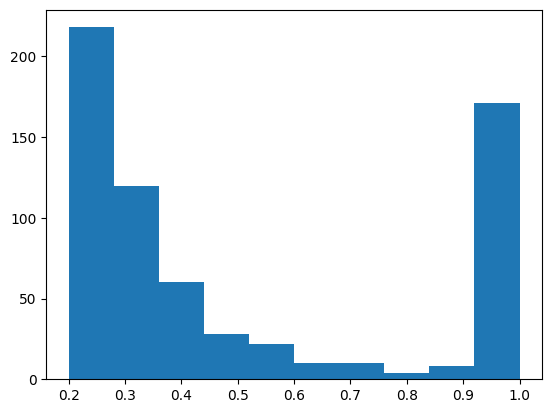

In [20]:
dist_mat = similarity_matrix.reshape(-1)
plt.hist(dist_mat, range = (0.2, 1))
plt.show()

In [55]:
prices = wine_data[["variety", "price"]].groupby("variety").agg('mean')
bins = [8, 25, 50, 80]
clusters = pd.cut(prices["price"], bins, labels = ["cheap", "normal", "expensive"])


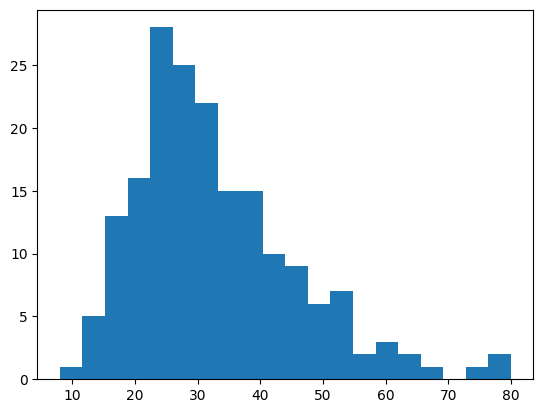

In [56]:
plt.hist(prices, bins = 20)
plt.show()

In [58]:
import json
price_labels = [clusters[key] for key in variety_dict_keys]
json_nodes = []
json_links = []
current_i = 0
diff = np.zeros(len(variety_dict_keys), dtype=int)
current_node, past_node = 0, 0
for (i, j), value in np.ndenumerate(similarity_matrix):
    if(current_i != i):
        current_i = i
        if(past_node == current_node):
            diff[i:] += 1
            continue
        past_node = current_node
        json_nodes.append({'name' : variety_dict_keys[i-diff[i]], 'group' : price_labels[i-diff[i]]})
    if(similarity_matrix[i, j] > 0.2 and i!=j):
        current_node +=1
for (i, j), value in np.ndenumerate(similarity_matrix):
    if(similarity_matrix[i, j] > 0.2 and i!=j):
        json_links.append({'source' : int(i-diff[i]), 'target' : int(j-diff[j]), 
                           'value' : int(100*(similarity_matrix[i, j] - 0.2)+1)})
print(json_links)
print(similarity_matrix)

[{'source': 0, 'target': 16, 'value': 36}, {'source': 0, 'target': 20, 'value': 7}, {'source': 0, 'target': 30, 'value': 9}, {'source': 1, 'target': 2, 'value': 34}, {'source': 1, 'target': 3, 'value': 11}, {'source': 1, 'target': 4, 'value': 19}, {'source': 1, 'target': 5, 'value': 12}, {'source': 1, 'target': 8, 'value': 17}, {'source': 1, 'target': 13, 'value': 10}, {'source': 1, 'target': 14, 'value': 3}, {'source': 1, 'target': 16, 'value': 14}, {'source': 1, 'target': 27, 'value': 13}, {'source': 1, 'target': 32, 'value': 4}, {'source': 1, 'target': 83, 'value': 1}, {'source': 1, 'target': 105, 'value': 2}, {'source': 2, 'target': 1, 'value': 34}, {'source': 2, 'target': 3, 'value': 7}, {'source': 2, 'target': 4, 'value': 17}, {'source': 2, 'target': 5, 'value': 5}, {'source': 2, 'target': 8, 'value': 12}, {'source': 2, 'target': 9, 'value': 8}, {'source': 2, 'target': 13, 'value': 4}, {'source': 2, 'target': 14, 'value': 15}, {'source': 2, 'target': 16, 'value': 16}, {'source': 

In [ ]:
final_json = {"links" : json_links, "nodes" : json_nodes}
output_file = open(parent + "data/force_graph.json", "w")
json.dump(final_json, output_file)
output_file.close()